# Франко-русский переводчик на основе правил (RBMT) 

### Будем использовать метод **интерлингва** -- т.е. будем оперировать языковыми представлениями (репрезентациями), которые сначала определим на концептуальном уровне.  

##### Интересно, что эта методология восходит к истокам машинного перевода -- к 1935 году, когда был предложен проект "машины Смирнова-Троянского": основная идея прибора также заключалась в том, чтобы привести текст на языке оригинале к некой концептуальной металингвистической норме, а затем преобразовать данные представления в переведенный текст. 

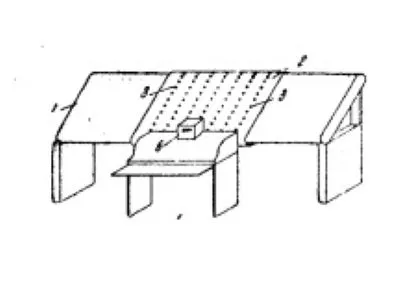![image.png](attachment:8ab5920b-2c41-4a70-a3f6-a6d70b6730d9.png=50)

### Алгоритм 

    1. создаем двуязычный лексикон в формате храналища ключ-значение 
    2. принимаем на вход текст на source language 
    3. токенизацизируем текст и проводим частеречный анализ (pos)   
    3.1. для каждой части речи находим соответствующий экземпляр-хранилище 
    3.2. проводим морфологический анализ формы слова и находим нужную форму для target language 
    3.2.1. опускаем негативную частицу 'pas' -- для перевода на русский ее значение избыточно 
    3.2.2. переводим возвратное местоимение
    3.2.3. опускаем глагол "être" -- избыточен в переводе на русский 
    3.3. собираем функцией transfer текст на языке таргета 
    3.4. нормализация орфографии (заглавная буква для первого слова текста на языке таргета) 
    4. вывод переведенного текста
    
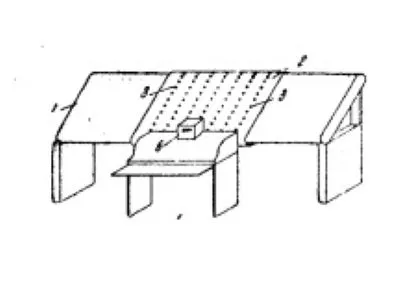

In [24]:
class TestFrenchRussianTranslator:
    def __init__(self):
        self.bilingual_dict = {
            'aujourd\'hui': 'сегодня',
            'il': 'он',
            'se': 'себя',
            'considère': 'считает',
            'malade': ('больным', 'больна'), # записаваем в значение tuple с двумя вариантами перевода
            'ne': 'не',
            'elle': 'она',
            'est': 'есть'
        }
        
        self.verbs = {'considère', 'être', 'est'}
        self.reflexive_verbs = {'considère'}
        self.negation = {'ne'}
    
    def analysis(self, source_text):
        source_tokens = source_text.replace('.', '').lower().split()
        self.pos_tags = ['V' if word in self.verbs else 'NEG' if word == 'ne' else 'REFL' if word == 'se' else '' for word in source_tokens]
        return source_tokens, self.pos_tags
    
    def transfer(self, source_tokens):
        target_tokens = []
        i = 0
        negation_added = False # контролируем перевод 'pas', чтобы избежать двойного отрицавания в таргете 
        
        while i < len(source_tokens):
            current_token = source_tokens[i]
            
            if current_token in {'ne', 'pas', 'se', 'est'}:
                if current_token == 'ne' and not negation_added:
                    target_tokens.append('не')
                    negation_added = True
            elif current_token == 'malade': 
                for prev_token in source_tokens: # запускаем подцикл for, чтобы посмотреть в контексте, какого рода местоимение 
                    if prev_token == 'elle': 
                        target_tokens.append(self.bilingual_dict[current_token][1]) 
                        break 
                    else:
                        target_tokens.append(self.bilingual_dict[current_token][0]) 
                        break 
            elif current_token in self.reflexive_verbs:
                target_tokens.append(self.bilingual_dict[current_token])
                target_tokens.append('себя')
            else:
                target_tokens.append(self.bilingual_dict[current_token])
            i += 1
            
        return target_tokens
    
    def generation(self, target_tokens):
        result = ' '.join(token for token in target_tokens if token)
        return result[0].upper() + result[1:] + '.' 
    
    def translate(self, source_text):
        source_tokens, pos_tags = self.analysis(source_text)
        target_tokens = self.transfer(source_tokens)
        result = self.generation(target_tokens)
        
        print(f"Source text: {source_text}")
        print(f"Tokens: {source_tokens}")
        print(f"POS tags: {pos_tags}")
        print(f"Transfer result: {target_tokens}")
        print(f"Final translation: {result}")

# Test examples
translator = TestFrenchRussianTranslator()
translator.translate("Aujourd'hui il ne se considère pas malade")
translator.translate("Elle est malade")  



Source text: Aujourd'hui il ne se considère pas malade
Tokens: ["aujourd'hui", 'il', 'ne', 'se', 'considère', 'pas', 'malade']
POS tags: ['', '', 'NEG', 'REFL', 'V', '', '']
Transfer result: ['сегодня', 'он', 'не', 'считает', 'себя', 'больным']
Final translation: Сегодня он не считает себя больным.
Source text: Elle est malade
Tokens: ['elle', 'est', 'malade']
POS tags: ['', 'V', '']
Transfer result: ['она', 'больна']
Final translation: Она больна.
